## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Camera calibration

In [98]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt
import pickle
%matplotlib inline

def camera_cal():
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(500)
    cv2.destroyAllWindows()
    return objpoints, imgpoints
objpoints, imgpoints = camera_cal()


## Calculate distortion coefficients and save them

In [99]:
image_filenames = ['straight_lines1.jpg', 'straight_lines2.jpg', 'test1.jpg','test2.jpg','test3.jpg','test4.jpg','test5.jpg','test6.jpg']
test = 2
image_test = 'test_images/' + image_filenames[test]
img = cv2.imread(image_test)

def save_dist_coeff(img,objpoints,imgpoints):
    img = cv2.imread(image_test)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump(dist_pickle, open("camera_cal/dist_pickle.p", "wb" ) )
    return mtx, dist

mtx,dist = save_dist_coeff(img,objpoints,imgpoints)


## Apply a distortion correction to raw images (function cal_undistort)

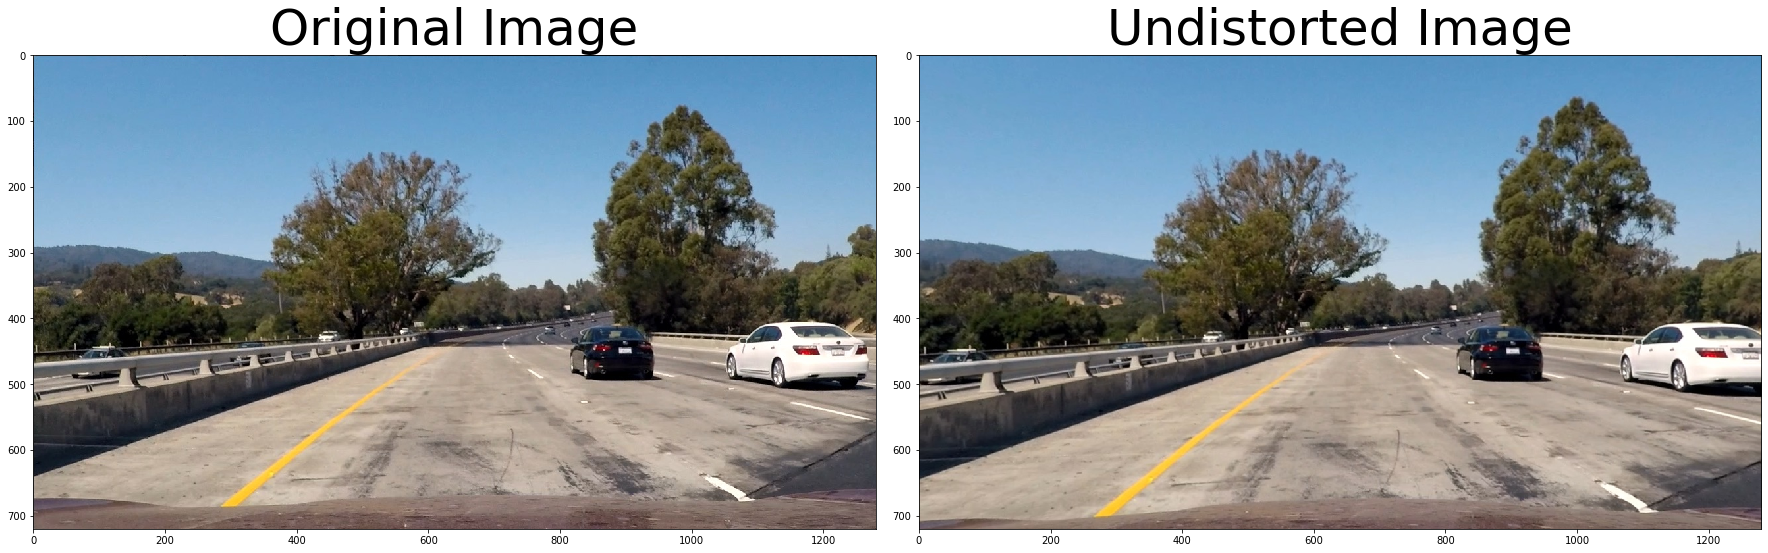

In [100]:
# Read in the saved objpoints and imgpoints
dist_pickle = pickle.load(open("camera_cal/dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Function that takes an image and returns the undistorted image
def cal_undistort(img, mtx, dist):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

undistorted = cal_undistort(img, mtx,dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(np.array(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(np.array(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)))
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Use color transforms, gradients, etc., to create a thresholded binary image.

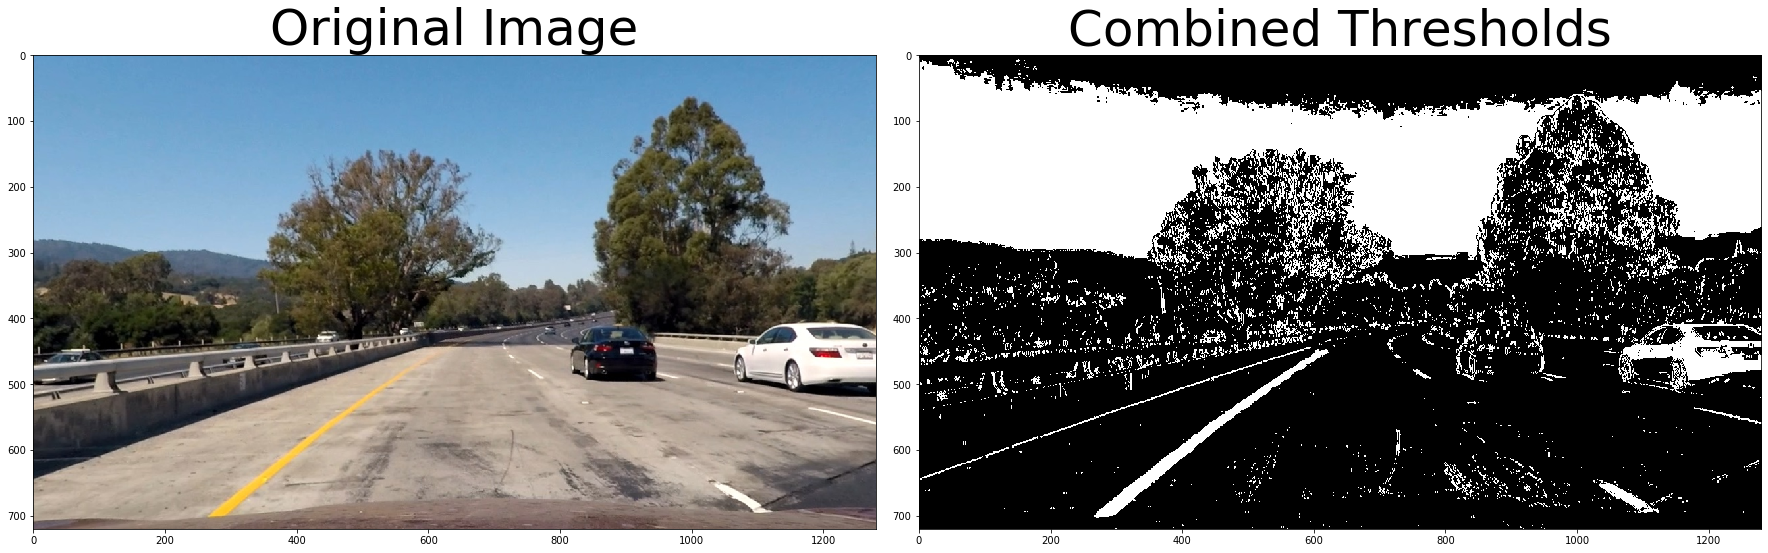

In [101]:
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=20, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh=(0,255),sobel_kernel=15):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1*orient == 'x', 1 * orient=='y',ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary


def color_s_threshold (img,thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

def color_red_threshold (img,thresh=(0,255)):
    R = img[:,:,2]
    binary = np.zeros_like(R)
    binary[(R > thresh[0]) & (R <= thresh[1])] = 1
    return binary

def transform_thresholded(image):
    #image = mpimg.imread('signs_vehicles_xygrad.png')
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    #grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(200, 255))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(80, 200))
    dir_binary = dir_threshold(image, sobel_kernel=3, thresh=(0.7, 1.3))
    color_S_binary = color_s_threshold(image, thresh=(100,255))
    color_red_binary = color_red_threshold(image, thresh=(100,255))

    combined = np.zeros_like(dir_binary)

    combined[(gradx == 1) | (color_S_binary == 1) & (color_red_binary == 1)] = 1
    #after multiple trials, I found that combining Red filtering and S filtering is efficient to detect yellow lines and remove shadows
    return combined

image = np.copy(undistorted)
combined = transform_thresholded(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(np.array(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')


ax2.set_title('Combined Thresholds', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Apply a perspective transform to rectify binary image ("birds-eye view").

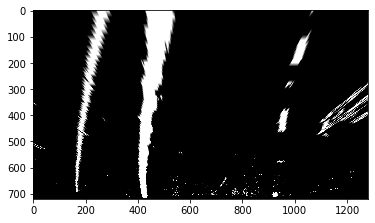

In [102]:
image = np.copy(combined)
img_size = (image.shape[1], image.shape[0])

#source points - manual selection
y_bottom = 720
y_top = 450
src_x1 = 240 #bottom left
src_x2 = 1040 #bottom right
src_x3 = 600 #top left
src_x4 = 680 #top right

shrink_base_factor = 0.55

dest_x1 = src_x1 + (src_x2 - src_x1) * (1- shrink_base_factor) / 2
dest_x2 = src_x2 - (src_x2 - src_x1) * (1- shrink_base_factor) / 2

src = np.float32([[src_x1,y_bottom],[src_x2,y_bottom],[src_x3,y_top],[src_x4,y_top]])
dst = np.float32([[dest_x1,y_bottom],[dest_x2,y_bottom],[dest_x1,0],[dest_x2,0]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
    

def perspective_transform(image):
    
    # Given src and dst points, calculate the perspective transform matrix
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(image, M, img_size)
    return warped

warped = perspective_transform(combined)
plt.imshow(warped,cmap='gray')

## Detect lane pixels and fit to find the lane boundary.

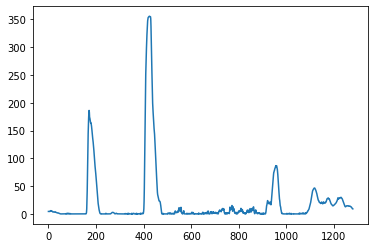

In [103]:
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and visualize the result

# Visualize the resulting histogram
plt.plot(histogram)

out_img = np.dstack((warped, warped, warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# HYPERPARAMETERS
# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50

# Set height of windows - based on nwindows above and image shape
window_height = np.int(warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated later for each window in nwindows
leftx_current = leftx_base
rightx_current = rightx_base

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


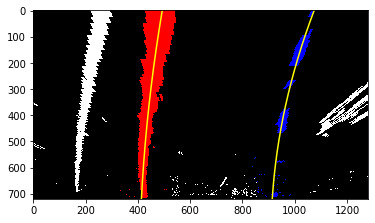

In [104]:
def search_from_scratch(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    
    nonzero = binary_warped.nonzero()
    
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated later for each window in nwindows
    
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        #(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),
        #(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
   
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty


#This function is not used in the pipeline videos
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty = search_from_scratch(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')    
    return out_img

#leftx, lefty, rightx, righty = search_from_scratch(warped)
out_img = fit_polynomial(warped)
plt.imshow(out_img)

In [105]:
def fit_polynomial_init(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit,right_fit

## Determine the curvature of the lane and vehicle position with respect to center.

## Warp the detected lane boundaries back onto the original image.

In [106]:
def draw_poly (undist,warped, left_fitx, right_fitx, ploty):
    global Minv
    global img_size
   
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    plt.imshow(result)
    
    return result


## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

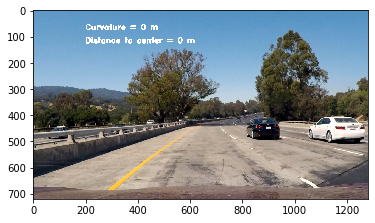

In [107]:
curvature_value = 0
distance_to_center_value = 0
def display_text_over_image(img,text,position):

    cv2.putText(
        img, #numpy array on which text is written
        text, #text
        position, #position at which writing has to start
        cv2.FONT_HERSHEY_DUPLEX, #font family
        1, #font size
        (255, 255, 255, 255), #font color
        3) #font stroke
    return img

image_filenames = ['straight_lines1.jpg', 'straight_lines2.jpg', 'test1.jpg','test2.jpg','test3.jpg','test4.jpg','test5.jpg','test6.jpg']
test = 2
image_test = 'test_images/' + image_filenames[test]
img = cv2.imread(image_test)

position1 = (200,75)
text_to_display1 = 'Curvature = ' + str(curvature_value) + ' m'

position2 = (200,125)
text_to_display2 = 'Distance to center = ' + str(distance_to_center_value) + ' m'

img = display_text_over_image (img, text_to_display1,position1)
img = display_text_over_image (img, text_to_display2,position2)

plt.imshow(np.array(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))


In [108]:
def measure_curvature_real(ploty, left_fit_cr,right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    max_curve = 2000 #max curvature measures (equivalent to straight lines)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Calculation of R_curve (radius of curvature)
    
    left_curverad = min(max_curve,((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0]))
    right_curverad = min(max_curve,((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0]))
    
    return left_curverad, right_curverad

### Search from prior

In [109]:

# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
       ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit_coeff = np.polyfit(lefty, leftx, 2)
    right_fit_coeff = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[1]-1, img_shape[1])
    
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit_coeff[0]*ploty**2 + left_fit_coeff[1]*ploty + left_fit_coeff[2]
    right_fitx = right_fit_coeff[0]*ploty**2 + right_fit_coeff[1]*ploty + right_fit_coeff[2]
    
    return left_fitx, right_fitx, ploty,left_fit_coeff,right_fit_coeff

def search_around_poly(binary_warped,left_fit,right_fit):
    # width of the margin around the previous polynomial to search
    margin = 75

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty


## Integrate into a video

In [110]:

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from statistics import mean 

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None 
        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])] 
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = 0
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

image_filenames = ['straight_lines1.jpg', 'straight_lines2.jpg', 'test1.jpg','test2.jpg','test3.jpg','test4.jpg','test5.jpg','test6.jpg']
test = 6
image_test = 'test_images/' + image_filenames[test]

img = cv2.imread(image_test)
img_size = (img.shape[1], img.shape[0])
objpoints, imgpoints = camera_cal()
mtx, dist = save_dist_coeff(img, objpoints,imgpoints)

In [ ]:

#Initialize left lane and right lane instances of the class Line()
left_lane = Line()
right_lane = Line()

#Global variables
consecutive_undetected_count = 100
total_undetected_count = 0
prior_count=0
scratch_count = 0

def process_image(image):
    global prior_count, scratch_count
    global consecutive_undetected_count, total_undetected_count
    
    undetected_threshold = 3 #number of images when lanes were undecteted, triggering a new search from scratch
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ym_per_pix = 30/720 # meters per pixel in y dimension


    lane_pixel_threshold = 15000 # minimum number of pixels to detect a lane
    diff_curvature_threshold = 500
    min_distance_btw_lines_threshold = 100
    parallelism_threshold = 75
    
    smoothing_nfits = 5 #number of frames to average the fitting values
    
    undistorted = cal_undistort(image, mtx,dist)
    
    # detect lanes
    trans_thresholded_binary = transform_thresholded (undistorted)

    # apply a perspective transform
    persp_binary = perspective_transform(trans_thresholded_binary)
    
    # define the search method based on the last detected lanes
    
    if left_lane.detected == False: #I assume that left_lane.detected = right_lane.detected
        consecutive_undetected_count += 1
    else:
        consecutive_undetected_count = 0 #reset to 0 if both lanes were previously detected
        
    if consecutive_undetected_count>= undetected_threshold:
        #search_from_scratch
        # returns all the leftx, lefty, rightx, righty
        leftx, lefty, rightx, righty = search_from_scratch (persp_binary)
        scratch_count+=1

    else:
        #search_from_prior
        prior_count+=1
        leftx, lefty, rightx, righty = search_around_poly (persp_binary, left_lane.current_fit,right_lane.current_fit)
        
    # Calculer le polynome
    left_fitx, right_fitx, ploty,left_fit_coeff,right_fit_coeff = fit_poly(img_size, leftx, lefty, rightx, righty)
    
    ploty = np.linspace(0, undistorted.shape[0]-1, undistorted.shape[0])
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad, right_curverad = measure_curvature_real(ploty, left_fit_cr,right_fit_cr)
    
    #Sanity_Check #1: minimum number of pixels detected
    min_pixel_detected = (len(leftx) > lane_pixel_threshold) and (len(rightx) > lane_pixel_threshold)
    
    #Sanity_Check #2: curvature is similar
    similar_curvature = True #abs(left_curverad - right_curverad) < diff_curvature_threshold
    
    #Sanity_Check #3: mid_point (y = 359) distance between lines must be within a reasonable range
    min_distance_btw_lines = (450 < (right_fitx[359] - left_fitx[359]) < 550)
    
    #Sanity_check #4: the 2 lines are parallel - distance between the 2 lanes at the top and bottom are not too far apart
    
    parallel_value = abs((right_fitx[0] - left_fitx[0]) - (right_fitx[719] - left_fitx[719]))
    parallelism = parallel_value < parallelism_threshold
    
    sanity_checks = min_pixel_detected and similar_curvature and min_distance_btw_lines and parallelism
    if sanity_checks:
        'update class lane'
        
        left_lane.detected = True
        left_lane.allx = leftx
        left_lane.ally = lefty
        right_lane.allx = rightx
        right_lane.ally = righty
        
        left_lane.recent_xfitted.append (left_fitx)
        if len(left_lane.recent_xfitted) > smoothing_nfits:
            del left_lane.recent_xfitted[0]
            
        right_lane.recent_xfitted.append (right_fitx)
        if len(right_lane.recent_xfitted) > smoothing_nfits:
            del right_lane.recent_xfitted[0]
        
        left_lane.bestx = np.array(left_lane.recent_xfitted).mean(axis=0)
        left_lane.best_fit = None
        left_lane.diffs = left_fit_coeff - left_lane.current_fit
        left_lane.current_fit = left_fit_coeff  
        left_lane.line_base_pos = left_lane.bestx[0]
        right_lane.bestx = np.array(right_lane.recent_xfitted).mean(axis=0)
        right_lane.best_fit = None  
        right_lane.diffs = right_fit_coeff - right_lane.current_fit
        right_lane.current_fit = right_fit_coeff 
        right_lane.line_base_pos = right_lane.bestx[0]

    else:
        left_lane.detected = False
        total_undetected_count+=1
                                    
    # Calculate distance to center
    distance_to_center = round((640 - (left_lane.line_base_pos + right_lane.line_base_pos) / 2) * xm_per_pix,2)    
    
    # Visualization
    new_img = draw_poly(image, persp_binary, left_lane.bestx,right_lane.bestx,ploty)    
    
    right_lane.radius_of_curvature = right_curverad
    left_lane.radius_of_curvature = left_curverad

    position1 = (200,75)
    text_to_display1 = 'Curvature (L,R) = ' + str(int(left_lane.radius_of_curvature)) + ' m; ' + str(int(right_lane.radius_of_curvature)) + ' m'
    
    position2 = (200,125)
    text_to_display2 = 'Distance to center = ' + str(distance_to_center)
    
    position3 = (800,75)
    text_to_display3 = 'Min Pixel: ' + str (len(leftx)) 

    position4 = (800,125)
    text_to_display4 = 'Diff Curv: ' + str(int(abs(left_curverad - right_curverad))) 

    position5 = (800,175)
    text_to_display5 = 'Undetected: ' + str(total_undetected_count) 
    
    position6 = (800,225)
    text_to_display6 = 'Parallel: ' + str(int(parallel_value)) 
    
    position7 = (800,275)
    text_to_display7 = 'Scratch no: ' + str(int(scratch_count)) 

    position8 = (200,225)
    text_to_display8 = 'Le Bolide de Cap Breton!'
    
    
    new_img = display_text_over_image (new_img, text_to_display1,position1)
    new_img = display_text_over_image (new_img, text_to_display2,position2)
    new_img = display_text_over_image (new_img, text_to_display3,position3)
    new_img = display_text_over_image (new_img, text_to_display4,position4)
    new_img = display_text_over_image (new_img, text_to_display5,position5)
    new_img = display_text_over_image (new_img, text_to_display6,position6)
    new_img = display_text_over_image (new_img, text_to_display7,position7)
    new_img = display_text_over_image (new_img, text_to_display8,position8)

    result = new_img

    return result

white_output = 'test_videos_output/project_video.mp4'
#white_output = 'test_videos_output/challenge_video.mp4'

#clip1 = VideoFileClip("project_video.mp4").subclip(0,15)
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)




t:   0%|          | 2/1260 [00:00<01:42, 12.26it/s, now=None]

Moviepy - Building video test_videos_output/project_video.mp4.
Moviepy - Writing video test_videos_output/project_video.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/project_video.mp4
CPU times: user 11min 42s, sys: 42.7 s, total: 12min 25s
Wall time: 3min 3s
